In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import misc
import numpy as np
from glob import glob
from PIL import Image
from numpy.linalg import norm
import os
import re
from sklearn.decomposition import PCA

In [263]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray / 255.

def readBmp(path):
    img = misc.imread(path).astype(np.double)
    d1, d2, channels = img.shape
    img = rgb2gray(img) * 255.
    return np.reshape(img, d1 * d2)
    
def plotHeatMap(img, w, h, savePath):
    cmap = matplotlib.cm.get_cmap('Reds')
    plot = plt.imshow(np.reshape(img, (w, h)))
    plot.set_cmap(cmap)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.savefig(savePath, format = 'png', bbox_inches='tight')
    plt.show()    
    
def saveBmpToGif(path, fname):
    img = misc.imread(path+fname).astype(np.double)
    d1, d2, channels = img.shape
    Image.fromarray( (rgb2gray(img) * 255. ).reshape(d1, d2) ).save(path+'out.gif')
    
def readImagesIntoMatrix(path, name):
    names = sorted(glob(path + "/" +name))
    d1, d2, channels = misc.imread(names[0]).shape
    num = len(names)
    X = np.zeros((d1, d2, num))
    for n, i in enumerate(names):
        img = misc.imread(i).astype(np.double)
        X[:, :, n] = misc.imresize(rgb2gray(img) / 255., (d1, d2))
    
    X = X.reshape(d1 * d2, num)
    return (X, d1, d2)

def saveImagesWithDim(path, images, width, height):
    for i in range(0, len(images)):
        Image.fromarray(np.uint8(images[i]).reshape(height, width)).save(path+str(i)+'.gif')    

def saveImages(path, A, E, d1, d2):
    for i in range(0, len(A)):
        noiseName = 'noise_' + str(i) + '.png'
        bgName = 'lowRank_' + str(i) + '.png'
        Image.fromarray(np.uint8(E[i].reshape(d1,d2))).save(path+noiseName)
        Image.fromarray(np.uint8(A[i].reshape(d1,d2))).save(path+bgName)        
        
def rpcaOnImages(source, dest, lmbda):
    fdir = source
    names = sorted(glob(fdir + "images/*.bmp"))
    d1, d2, channels = misc.imread(names[0]).shape
    num = len(names)
    X = np.zeros((d1, d2, num))
    for n, i in enumerate(names):
        img = misc.imread(i).astype(np.double)
        X[:, :, n] = misc.imresize(rgb2gray(img) / 255., (d1, d2))

    bgImg =readBmp(source + '/background.bmp')
    
    X = X.reshape(d1 * d2, num)    
    A, E = inexact_augmented_lagrange_multiplier(X.T,lmbda=lmbda)
    
    pca = PCA(n_components=2, svd_solver='full')
    lowRank = pca.fit_transform(A.T)
    reconstructed = pca.inverse_transform(lowRank).T
    
    error = bgImg - reconstructed
    for i in range(0, 1):
        plotHeatMap(np.absolute(error[i]), d1, d2, dest + 'hm_'+str(i)+ '_' + str(lmbda) + '.png')
    rre = norm(error, axis=1) / norm(bgImg)
    saveImages(dest, A, E, d1, d2)
    return rre
    
def pcaOnImages(source, dest, n):
    M, w, h = readImagesIntoMatrix(source+"images/", '*.bmp')
    pca = PCA(n_components=n, svd_solver='full')
    lowRank = pca.fit_transform(M)
    
    reconstructed = pca.inverse_transform(lowRank).T

    bgImg =readBmp(source + '/background.bmp')
    
    # calculate total fro error
    error = bgImg - reconstructed
    rre = norm(error, axis=1) / norm(bgImg)
    for i in range(0, 1):
        plotHeatMap(np.absolute(error[i]), w, h, dest + 'hm_'+str(i)+'.png')
    
    noise = M.T - reconstructed
    saveImages(dest, reconstructed, noise, w, h)    
    return rre 

def plotLine(pca1, pca2, rpca, title, xLabel, lmbda, savePath, yLim=0.25):
    xdata = []
    yPCAdata = []
    yPCA2data = []
    yRPCAdata = []
    for i in range(len(pca1)):
        xdata.append(i)
        yPCAdata.append(pca1[i])
        yPCA2data.append(pca2[i])
        yRPCAdata.append(rpca[i])

    fig = plt.figure()
    fig.suptitle(title)
    plt.plot(xdata, yPCAdata, label="PCA (1 PC)")
    plt.plot(xdata, yPCA2data, label="PCA (2 PCs)")
    plt.plot(xdata, yRPCAdata, label="RPCA (lambda = "+str(lmbda)+")")
    plt.xlabel(xLabel)
    plt.ylabel("Relative Error")
    plt.ylim(0,yLim)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend(bbox_to_anchor=(1.0, 0.95))
    plt.savefig(savePath, format = 'png')
    plt.show()
    plt.close()
    
    
import numpy as np
from numpy.linalg import norm, svd
from scipy.io import loadmat, savemat
from numpy.linalg import matrix_rank

def inexact_augmented_lagrange_multiplier(X, lmbda=.01, tol=1e-3,
                                          maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """
    Y = X
    norm_two = norm(Y.ravel(), 2)
    norm_inf = norm(Y.ravel(), np.inf) / lmbda
    dual_norm = np.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = np.zeros(Y.shape)
    E = np.zeros(Y.shape)
    dnorm = norm(X, 'fro')
    mu = 1.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
        Eraw = X - A + (1 / mu) * Y
        Eupdate = np.maximum(Eraw - lmbda / mu, 0) + np.minimum(Eraw + lmbda / mu, 0)
        U, S, V = svd(X - Eupdate + (1 / mu) * Y, full_matrices=False)
        svp = (S > 1 / mu).shape[0]
        if svp < sv:
            sv = np.min([svp + 1, n])
        else:
            sv = np.min([svp + round(.05 * n), n])
        Aupdate = np.dot(np.dot(U[:, :svp], np.diag(S[:svp] - 1 / mu)), V[:svp, :])
        A = Aupdate
        E = Eupdate
        Z = X - A - E
        Y = Y + mu * Z
        mu = np.min([mu * rho, mu * 1e7])
        itr += 1
        if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
            break
    if verbose:
        print("Finished at iteration %d" % (itr))  
    return A, E

#saveBmpToGif('videos/aquarium/', 'background.bmp')

Finished at iteration 22


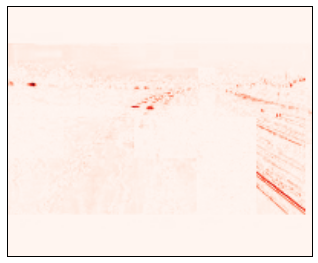

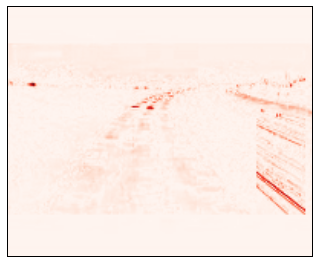

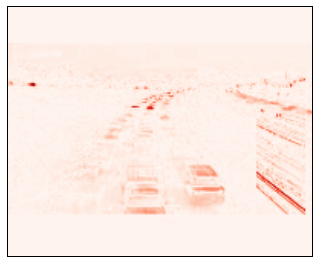

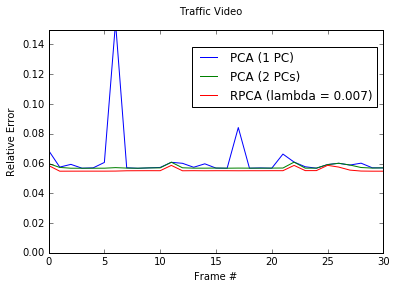

Finished at iteration 16


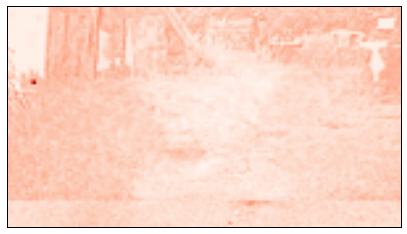

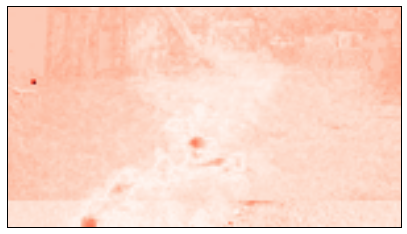

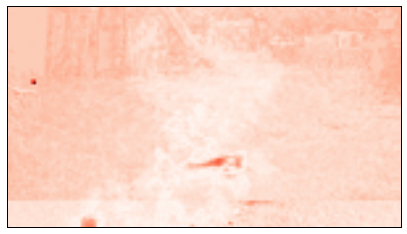

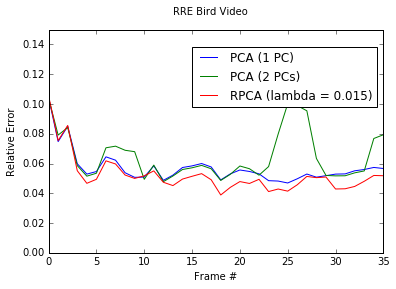

In [270]:
rpca = rpcaOnImages('videos/traffic/', 'videos/traffic/rpca/', 0.007)
pca2 = pcaOnImages('videos/traffic/', 'videos/traffic/pca/', 1)
pca = pcaOnImages('videos/traffic/', 'videos/traffic/pca2/', 2)

plotLine(pca, pca2, rpca, 'Traffic Video', 'Frame #', 0.007,  'figures_video/traffic/rre_007.png', 0.15)

rpca = rpcaOnImages('videos/crow/', 'videos/crow/rpca/', 0.015)
pca = pcaOnImages('videos/crow/', 'videos/crow/pca/', 1)
pca2 = pcaOnImages('videos/crow/', 'videos/crow/pca2/', 2)

plotLine(pca, pca2, rpca, 'RRE Bird Video', 'Frame #', 0.015, 'figures_video/crow/rre_015.png', 0.15)

# rpca = rpcaOnImages('videos/crow_oneoff/', 'videos/crow_oneoff/rpca/', 0.02)
# pca = pcaOnImages('videos/crow_oneoff/', 'videos/crow_oneoff/pca/', 1)
# pca2 = pcaOnImages('videos/crow_oneoff/', 'videos/crow_oneoff/pca2/', 2)

# plotLine(pca, pca2, rpca, 'Bird Video (PCA, 2PC)', 'Frame #', 0.02)

#rpcaOnImages('videos/city/images/', 'videos/city/rpca/', 0.004)
#pcaOnImages('videos/city/images/', 'videos/city/pca/', 1)

In [ ]:
print readBmp('videos/traffic/background.bmp')

In [249]:
#saveBmpToGif('videos/aquarium/', 'background.bmp')

In [203]:
rpca = PCA(n_components=1, svd_solver='full')
images = rpca.fit_transform(A)
rpcaRecImages = rpca.inverse_transform(images)
#saveImagesWithDim('videos/animal/rpca/rec/', rpcaRecImages, d2, d1)


(56L, 1L)


In [3]:
v = [1,2,3]
norm(v)

3.7416573867739413

# PCA Section

(22600L, 56L)


(22600L, 56L)


# Analysis